# Airbnb Project

# Introduction
[Airbnb](http://airbnb.com) is an online marketplace for arranging or offering lodgings. In this project we will use Spark to analyze data obtained from the Airbnb website. The purpose of the analysis is to extract information about trends and patterns from the data.

The project has two parts.

### Part 1: Loading, describing and preparing the data
We will load, parse and prepare the data for the analysis in part two. This means cleaning it and staging it so that subsequent queries are fast.

### Part 2: Analysis
In this part we will learn about trends and usage patterns from the data. 

### Create Spark session and define imports

In [1]:
from pyspark.sql import *
from pyspark.sql import functions as f
from pyspark.sql.types import *

spark = SparkSession.builder.appName("SparkIntro").getOrCreate()

Additional imports for analysis

In [2]:
from statistics import mean 
from collections import Counter
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import matplotlib.dates
import numpy as np
import calendar

# Part 1: Loading, describing and preparing the data
The data comes in two files. We will Start by downloading the files and putting them in our `data/` folder.

- [Listings](https://files.dtu.dk/u/siPzAasj8w2gI_ME/listings.csv?l) (5 GB)
- [Reviews](https://files.dtu.dk/u/k3oaPYp6GjKBeho4/reviews.csv?l) (9.5 GB)

### Load the data
The data has multiline rows (rows that span multiple lines in the file), so we will parse these using the `multiline` option and set the `escape` character `"`.

Both datasets are loaded into a spark dataframe each

In [3]:
listings_df = spark.read\
    .option('header', True)\
    .option('inferSchema', True)\
    .option('multiline', True)\
    .option('escape', '"')\
    .csv('data/listings.csv')

In [4]:
reviews_df = spark.read\
    .option('header', True)\
    .option('inferSchema', True)\
    .option('multiline', True)\
    .option('escape', '"')\
    .csv('data/reviews.csv')

### Data description

**Features and size of the listings dataframe**

The features are printed

In [5]:
listings_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- listing_url: string (nullable = true)
 |-- scrape_id: string (nullable = true)
 |-- last_scraped: string (nullable = true)
 |-- name: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- space: string (nullable = true)
 |-- description: string (nullable = true)
 |-- experiences_offered: string (nullable = true)
 |-- neighborhood_overview: string (nullable = true)
 |-- notes: string (nullable = true)
 |-- transit: string (nullable = true)
 |-- access: string (nullable = true)
 |-- interaction: string (nullable = true)
 |-- house_rules: string (nullable = true)
 |-- thumbnail_url: string (nullable = true)
 |-- medium_url: string (nullable = true)
 |-- picture_url: string (nullable = true)
 |-- xl_picture_url: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_url: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- host_since: string (nullable = true)
 |-- host_location: string (nullable

The size is printed as rows x columns

In [6]:
listings_df_rows = listings_df.count()
listings_df_columns = len(listings_df.columns)

print("Size: {}x{}".format(listings_df_rows, listings_df_columns))

Size: 1330480x106


**Features and size of the reviews dataframe**

The features are printed

In [7]:
reviews_df.printSchema()

root
 |-- listing_id: string (nullable = true)
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- reviewer_id: string (nullable = true)
 |-- reviewer_name: string (nullable = true)
 |-- comments: string (nullable = true)



The size is printed as rows x columns

In [8]:
reviews_df_rows = reviews_df.count()
reviews_df_columns = len(reviews_df.columns)

print("Size: {}x{}".format(reviews_df_rows, reviews_df_columns))

Size: 32297300x6


### Data Preparation

#### Preparing the listings dataframe

##### Removing null values

First off, the distribution of null values in the listings dataframe will be examined

In [9]:
# Aggregate the count of null for each column
null_list = listings_df\
    .agg(*[(f.count(f.when(f.isnull(c), c))/listings_df_rows).alias(c) for c in listings_df.columns])

The data is collected and the columns which contains the highest frequency of null values are displayed for inspection

In [10]:
sorted(null_list.collect()[0].asDict().items(), key=lambda x: x[1], reverse=True)[:10]

[('thumbnail_url', 0.9999278455895617),
 ('medium_url', 0.9999278455895617),
 ('xl_picture_url', 0.9999278455895617),
 ('square_feet', 0.9884598039805184),
 ('monthly_price', 0.9293097228068066),
 ('weekly_price', 0.9100835788587578),
 ('license', 0.8362914136251578),
 ('neighbourhood_group_cleansed', 0.7870340027659191),
 ('jurisdiction_names', 0.6870896217906319),
 ('notes', 0.5661385364680416)]

It is apparent that the columns which has the highest frequency of null values are almost at 100%. Thus if na.drop is used, the dataset will be emptied. Therefore it is decided that the columns with a null value frequency higher than 40% are dropped.

In [11]:
bad_columns = [k for k, v in null_list.collect()[0].asDict().items() if float(v) > 0.4]

The bad columns in the listings dataframe are dropped and rows containing the remaining null values are removed.

In [12]:
listings_df = listings_df.drop(*bad_columns).na.drop()

##### Converting price to float

The price column values are displayed

In [13]:
listings_df.select(f.col('price')).show(5)

+---------+
|    price|
+---------+
|  $411.00|
|$1,106.00|
|$2,798.00|
|  $900.00|
|  $646.00|
+---------+
only showing top 5 rows



It is apparent that commas and symbols within the price will be a problem for future calculations in the analysis. Thus, these should be removed, such that the price can be converted to float type. The currency will be extracted and removed from the price column aswell.

In [14]:
# Create currency column
listings_df = listings_df.withColumn('currency', f.expr("substring(price, 0, 1)"))

# Convert price number to float
listings_df = listings_df.withColumn("price", f.expr("substring(price, 2, length(price))"))
listings_df = listings_df.withColumn('price', f.expr("replace(price, ',', '')"))
listings_df = listings_df.withColumn("price", listings_df.price.cast('float'))

# Drop any null conversions
listings_df = listings_df.na.drop()

In [15]:
listings_df.select(f.col('price'), f.col('currency')).show(5)

+------+--------+
| price|currency|
+------+--------+
| 411.0|       $|
|1106.0|       $|
|2798.0|       $|
| 900.0|       $|
| 646.0|       $|
+------+--------+
only showing top 5 rows



#### Preparing the reviews dataframe

##### Removing null values

The distribution of null values in the reviews dataframe will be examined

In [16]:
null_list = reviews_df\
    .agg(*[(f.count(f.when(f.isnull(c), c))/reviews_df_rows).alias(c) for c in reviews_df.columns])

The data is collected and the columns which contains the highest frequency of null values are displayed for inspection

In [17]:
sorted(null_list.collect()[0].asDict().items(), key=lambda x: x[1], reverse=True)[:10]

[('comments', 0.0004035631461453434),
 ('reviewer_name', 4.644351075786521e-07),
 ('listing_id', 0.0),
 ('id', 0.0),
 ('date', 0.0),
 ('reviewer_id', 0.0)]

It is apparent that we do not have the same problem as we did for the listings dataframe, thus the rows containing null values can be dropped readily

In [18]:
reviews_df = reviews_df.na.drop()

# Part 2: Analysis

## The basics
We will compute and show a dataframe with the number of listings and neighbourhoods per city.

In [19]:
# Count of listings and unique neighbourhoods grouped by city
listings_df.groupBy(f.col('city'))\
    .agg(f.count('id'), f.countDistinct('neighbourhood').alias('neighbourhood_count'))\
    .orderBy(f.desc('neighbourhood_count'))\
    .show()

+--------------+---------+-------------------+
|          city|count(id)|neighbourhood_count|
+--------------+---------+-------------------+
|Greater London|    14765|                148|
|        London|     6116|                144|
|       Toronto|     8955|                138|
|     San Diego|     5377|                103|
|    Washington|     3658|                102|
|   Los Angeles|    11030|                 91|
|        Berlin|     6471|                 90|
|      Portland|     2631|                 90|
|   Minneapolis|     1106|                 80|
|       Chicago|     4027|                 80|
|       Seattle|     4362|                 78|
|        Austin|     3820|                 77|
|        Denver|     2508|                 76|
|      New York|     6286|                 70|
|       Oakland|     1413|                 70|
|     Barcelona|     6476|                 67|
|        Madrid|     7144|                 66|
|         Paris|    20583|                 63|
|       Beiji

We will now go into a detailed analysis of airbnb postings for the city Stockholm

We will compute and visualize the number of listings of different property types per neighbourhood in Stockholm.

In [20]:
choosen_city = "Stockholm"

The listings dataframe is filtered by the choosen city

In [21]:
listings_df_by_city = listings_df.filter(f.col('city') == choosen_city)

The number of different property types (uniques) for each neighborhood are displayed

In [22]:
listings_df_by_city.groupBy(f.col('neighbourhood'))\
    .agg(f.countDistinct('property_type').alias('property_types'))\
    .show()

+--------------------+--------------+
|       neighbourhood|property_types|
+--------------------+--------------+
|Enskede-Årsta-Vantör|             8|
|         Kungsholmen|             6|
|       Rinkeby-Kista|             3|
|           Skarpnäck|             4|
|            Norrmalm|             4|
|       Spånga-Tensta|             3|
|Hägersten-Liljeho...|             9|
|              Älvsjö|             4|
|  Hässelby-Vällingby|             2|
|           Södermalm|             8|
|              Farsta|             4|
|          Skärholmen|             6|
|              Bromma|             4|
|           Östermalm|             6|
+--------------------+--------------+



## Prices
For summary stats, we will compute the minimum, maximum and average listing price in Stockholm. 

In [23]:
listings_df_by_city.select(f.max('price'), f.min('price'), f.avg('price')).show()

+----------+----------+-----------------+
|max(price)|min(price)|       avg(price)|
+----------+----------+-----------------+
|    9001.0|     117.0|1241.430513595166|
+----------+----------+-----------------+



We will now compute and visualize the distribution of listing prices in your city.

The data for plotting is collected. Collecting the prices by grouping the prices and counting the amount of each, returns a smaller dataframe to collect, instead of collecting all price values in the dataframe.

In [24]:
# Grouping prices and aggregating occurrences (amount) of each price
rows = listings_df_by_city.groupBy('price').agg(f.count('price').alias('amount')).orderBy('price').collect()

The collected data is plotted as a histogram, to visualize the distribution of listing prices in Stockholm

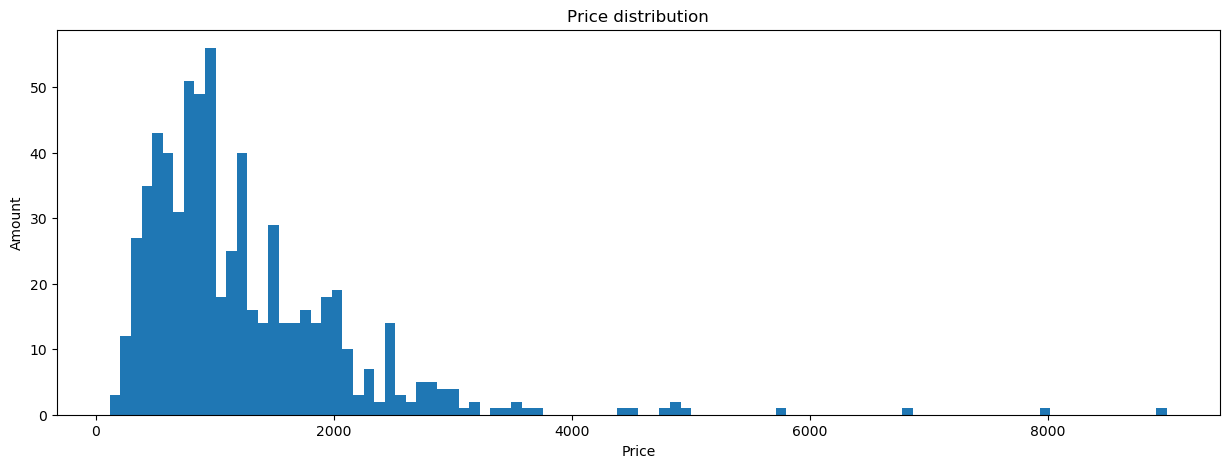

In [25]:
%matplotlib inline

plt.style.use('default')

x = list(map(lambda r: r['amount'], rows))
y = list(map(lambda r: r['price'], rows))

# Plot the distribution
plt.figure(figsize=(15,5))
plt.title("Price distribution")
plt.hist(y, weights=x, bins=100)
plt.xlabel("Price")
plt.ylabel("Amount")

plt.show()

It is apparent that the majority of listings in Stockholm has a price within the interval of 0 to 2000 USD

The value of a listing is its rating divided by its price. We will now compute and show a dataframe with the 3 highest valued listings in each neighbourhood.

The value of each listing is calculated. The top 3 highest value for each neighborhood are then displayed (the partitions are ordered by the listing value in descending order, and the complete list is ordered by neighbourhood name, only showing the first 20)

In [26]:
# A listing value column is calculated and selected with neighbourhood
listing_df_values = listings_df_by_city.withColumn('listing_value', f.col('review_scores_rating')/f.col('price'))\
    .select('neighbourhood', 'listing_value')

In [27]:
# Partition each neighbourhood by listing value
highest_listing_value_window = Window.partitionBy('neighbourhood').orderBy(f.desc('listing_value'))

# Uses ranks to create a ranked dataframe
ranked_df = listing_df_values.withColumn('Rank', f.rank().over(highest_listing_value_window))
ranked_df.filter(f.col('Rank') <= 3).drop('Rank').orderBy('neighbourhood', f.desc('listing_value')).show()

+--------------------+-------------------+
|       neighbourhood|      listing_value|
+--------------------+-------------------+
|              Bromma| 0.7948717948717948|
|              Bromma|            0.28125|
|              Bromma|0.27624309392265195|
|Enskede-Årsta-Vantör| 0.2882882882882883|
|Enskede-Årsta-Vantör|0.26881720430107525|
|Enskede-Årsta-Vantör|0.26704545454545453|
|              Farsta|0.33941605839416056|
|              Farsta| 0.3035143769968051|
|              Farsta|0.27722772277227725|
|Hägersten-Liljeho...| 0.4266666666666667|
|Hägersten-Liljeho...|0.36742424242424243|
|Hägersten-Liljeho...|0.35555555555555557|
|  Hässelby-Vällingby| 0.4634146341463415|
|  Hässelby-Vällingby| 0.4558139534883721|
|  Hässelby-Vällingby| 0.1524390243902439|
|         Kungsholmen| 0.2784090909090909|
|         Kungsholmen| 0.2506393861892583|
|         Kungsholmen|0.24552429667519182|
|            Norrmalm| 0.6054421768707483|
|            Norrmalm| 0.2127659574468085|
+----------

We can conclude that the listings of highest value are located in Bromma

## Trends
Now we want to analyze the "popularity" of Stockholm. 

The data does not contain the number of bookings per listing, but we have a large number of reviews, and we will assume that this is a good indicator of activity on listings.

### City trends

We will compute and visualize the popularity (i.e., number of reviews) of Stockholm over time.

When examining the schema of the review and listings, it is apparent that each review is linked to a listing by an ID. Thus, it is possible to join the columns 'city' and 'neighbourhood' from the listings dataframe to the the reviews dataframe.

In [28]:
#Get id, city and neighbourhood from listings
listings_df_for_join = listings_df_by_city\
    .select(f.col('id').alias('id_'), f.col('city'), f.col('neighbourhood'))

In [29]:
# Join listings and reviews
reviews_by_city = reviews_df.join(listings_df_for_join, (f.col('id_') == f.col('listing_id')))\
    .drop(f.col('id_'))

Lets take a look at the joined dataframe

In [30]:
reviews_by_city.show(5)

+----------+---------+----------+-----------+-------------+--------------------+---------+-------------+
|listing_id|       id|      date|reviewer_id|reviewer_name|            comments|     city|neighbourhood|
+----------+---------+----------+-----------+-------------+--------------------+---------+-------------+
|  13639296| 88077025|2016-07-23|   76359498|        Hafid|The apartment is ...|Stockholm|     Norrmalm|
|  13639296| 91699315|2016-08-06|   11549358|        Alain|The flat  is beau...|Stockholm|     Norrmalm|
|  13639296|112000668|2016-11-03|   98781470|     Riccardo|Ottima accoglienz...|Stockholm|     Norrmalm|
|  13639296|469162016|2019-06-14|  252371984|      Matheus|I really would li...|Stockholm|     Norrmalm|
|  13639296|471889460|2019-06-18|  101827501|       Corvus|Excellent locatio...|Stockholm|     Norrmalm|
+----------+---------+----------+-----------+-------------+--------------------+---------+-------------+
only showing top 5 rows



The number of reviews for the city of Stockholm are grouped by the date and then collected and visualized

In [31]:
rows = reviews_by_city.orderBy('date').groupBy('date').agg(f.count('id').alias('amount')).collect()

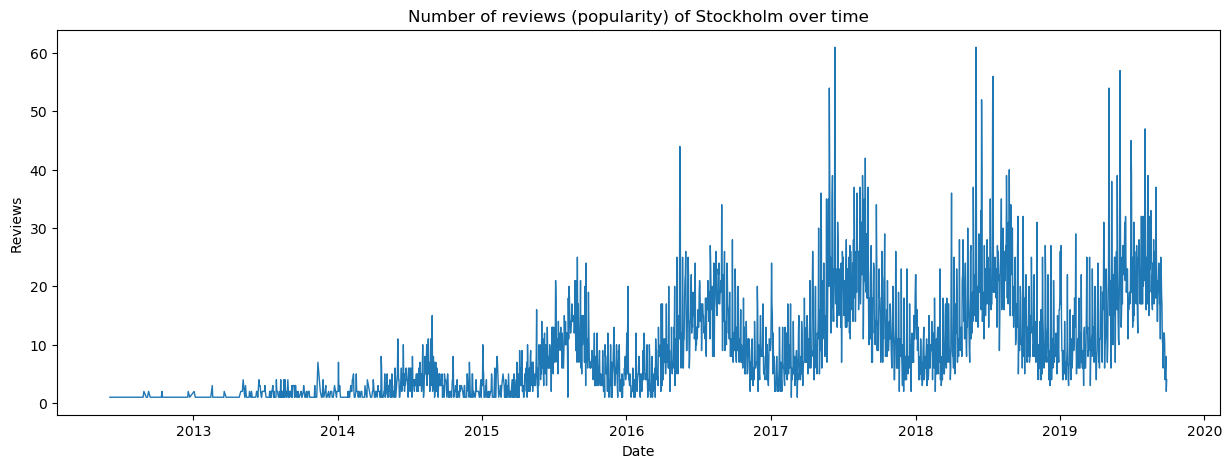

In [32]:
%matplotlib inline

plt.style.use('default')

# Plot reviews by date of choosen city
x = list(map(lambda r: datetime.strptime(r['date'], "%Y-%m-%d"), rows))
y = list(map(lambda r: r['amount'], rows))

plt.figure(figsize=(15,5))
plt.title("Number of reviews (popularity) of {} over time".format(choosen_city))
plt.plot(x, y, linewidth=1.0)

# show only years in x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(mdate.YearLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y"))

plt.xlabel("Date")
plt.ylabel("Reviews")

plt.show()

It is apparent that the popularity for airbnb's has generally increased throughout the years. Also, the popularity of listings in Stockholm seems to follow a specific pattern throughout a single year, indicating that certain seasons (mostly summer) are of higher popularity than others.

### Neighbourhood trends

We will now Compute and visualize the popularity of neighbourhoods in Stockholm over time.

The number of reviews in the city of Stockholm are grouped by the date and neighbourhood then collected and visualized

In [33]:
# The popularity is grouped by neighbourhood and date
neighbourhood_reviews = reviews_by_city.select(f.col('date'), f.col('id'), f.col('neighbourhood'))\
    .groupBy('date', 'neighbourhood')\
    .agg(f.count('id').alias('amount'))\
    .orderBy('neighbourhood', 'date')

In [34]:
# The neighbourhood review popularity is collected
city_neighbourhood_reviews = neighbourhood_reviews.collect()

# Unique neighbourhood list collected for legends
city_neighbourhood = listings_df_by_city.select(f.col('neighbourhood')).distinct().collect()
city_neighbourhood = list(map(lambda r: r['neighbourhood'], city_neighbourhood))

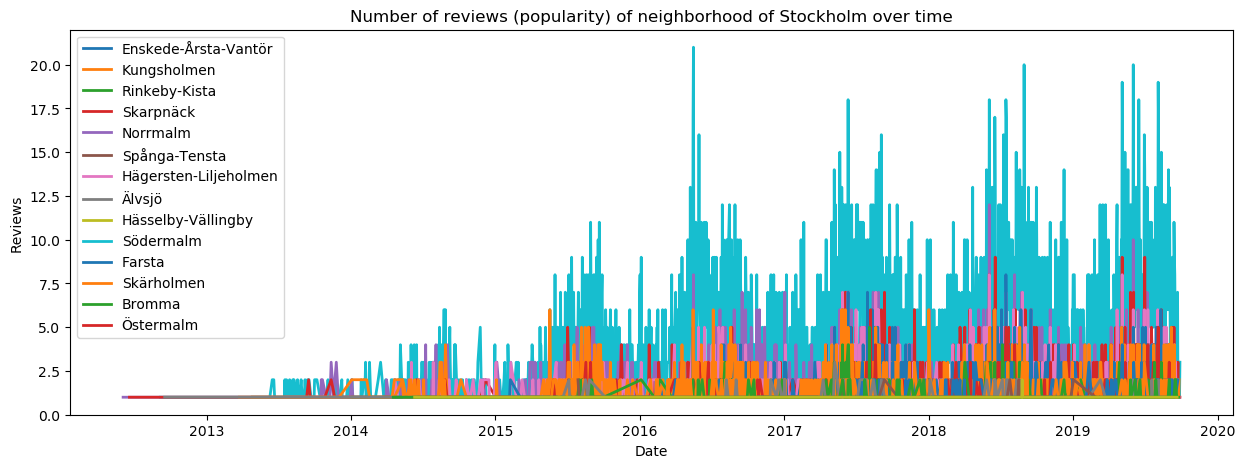

In [35]:
%matplotlib inline

plt.style.use('default')

plt.figure(figsize=(15, 5))
plt.title("Number of reviews (popularity) of neighborhood of {} over time".format(choosen_city))

# Plot each neighbourhood
handles = []
for neighbourhood in city_neighbourhood:
    data = list(filter(lambda r: r['neighbourhood'] == neighbourhood, city_neighbourhood_reviews))
    
    x = list(map(lambda r: datetime.strptime(r['date'], "%Y-%m-%d"), data))
    y = list(map(lambda r: r['amount'], data))

    handles.append(plt.plot(x, y, linewidth=2.0, zorder=-mean(y)))

plt.legend(city_neighbourhood)
plt.xlabel("Date")
plt.ylabel("Reviews")

plt.show()

The number of reviews in the city of Stockholm are grouped by month aswell as averaged by the number of years, and then collected and visualized

In [36]:
# Reviews grouped by month and the total amount of reviews for each month divided by number of years
rows = reviews_by_city.select(f.col('id'), f.col('date'), f.month('date').alias('month'))\
    .groupBy('month')\
    .agg((f.count('id')/(f.months_between(f.max('date'), f.min('date'))/12)).alias('popularity'))\
    .orderBy('month')\
    .collect()

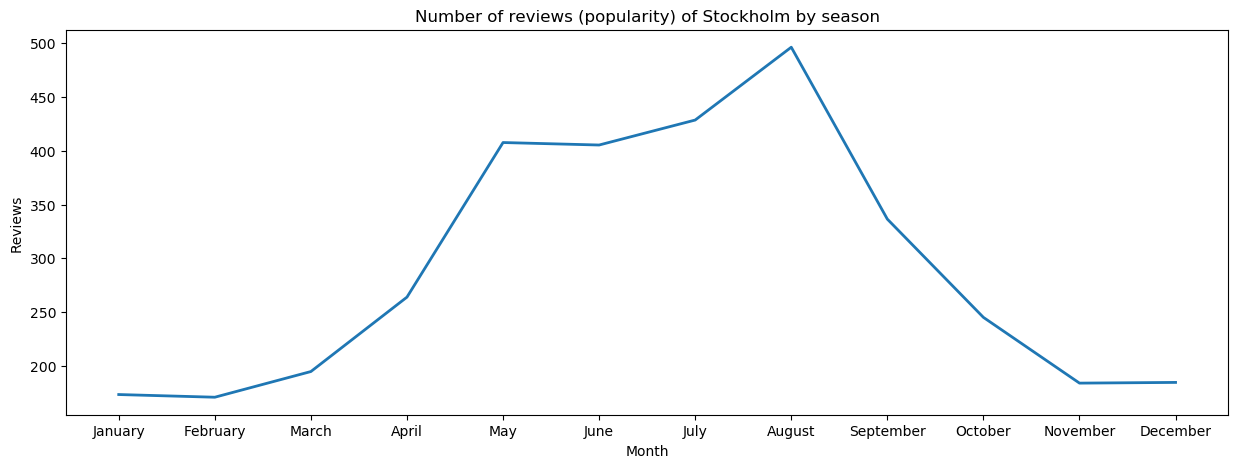

In [37]:
%matplotlib inline

plt.style.use('default')

# Plot the avg reviews pr month
x = list(map(lambda r: calendar.month_name[r['month']], rows))
y = list(map(lambda r: r['popularity'], rows))
    
plt.figure(figsize=(15,5))
plt.title("Number of reviews (popularity) of {} by season".format(choosen_city))
plt.plot(x, y, linewidth=2.0)
plt.xlabel("Month")
plt.ylabel("Reviews")

plt.show()

It is apparent that there is a significant spike in popularity in august for the city of Stockholm. Also, generally there seems to be a tendency of higher popularity in the spring and summer months.

## Reviews
In this part you should determine which words used in reviews that are the most positive. 

The individual reviews do not have a rating of the listing, so we will assume that each review gave the average rating to the listing, i.e., the one on the listing.

You should assign a positivity weight to each word seen in reviews and list the words with the highest weight. It is up to you to decide what the weight should be. For example, it can be a function of the rating on the listing on which it occurs, the number of reviews it occurs in, and the number of unique listings for which it was used to review.

Depending on your choice of weight function, you may also want to do some filtering of words. For example, remove words that only occur in a few reviews.

It is decided that the weighting, designating the 'positivity', of a listing should be the average of all review scores. Thus, a column containing the weight is added to a new, weight dataframe.

In [38]:
#Weight score based on review scores
weight_df = listings_df.withColumn('weight',\
    (f.col('review_scores_rating')\
    +f.col('review_scores_accuracy')\
    +f.col('review_scores_cleanliness')\
    +f.col('review_scores_communication')\
    +f.col('review_scores_location')\
    +f.col('review_scores_value'))\
    /6) # divided by the num of columns

weight_df = weight_df.select(f.col('id'), f.col('weight'))

The comments from the reviews are joined by the listing_id to the weight dataframe. Any null values occuring from the join are dropped. 

In [39]:
# Join weight score to reviews
weight_df = reviews_df.select('listing_id', 'comments')\
    .join(weight_df, f.col('id') == f.col('listing_id')).na.drop()

A new word column is created. This is done by splitting each comment into words. The words are then put into their own rows, with the weight from the comment they orignated from. Thus, each word from each comment is taken into consideration. By grouping the words, a total sum of the weights is calculated, thus ranking the words positivity by their weight.

In [40]:
# Split comments into row of words. Sort words by sum of weight.
weight_df = weight_df.withColumn('word', f.explode(f.split(f.col('comments'), ' ')))\
    .groupBy('word')\
    .agg((f.sum('weight')).alias('weight'))\
    .sort('weight', ascending=False)\

First off the dateframe is displayed with no filtering for any of the words

In [41]:
weight_df.show(50)

+----------+--------------------+
|      word|              weight|
+----------+--------------------+
|       and| 5.656598328333337E8|
|       the|4.4711486016665554E8|
|         a| 3.597440829999939E8|
|        to|3.5473381133332735E8|
|       was| 2.734920100000017E8|
|        is|2.3626841666666925E8|
|        in|2.0759729300000322E8|
|          |1.6924385116666785E8|
|        of|1.4781177616666684E8|
|      very|1.4714985083333343E8|
|       for| 1.409626861666665E8|
|       The|1.3850508849999997E8|
|         I|1.0860673149999928E8|
|      with|1.0672864549999903E8|
|        we| 9.591989816666605E7|
|     place|  9.41088808333327E7|
|     great| 9.295056549999961E7|
|      stay|  8.06967894999997E7|
|       you| 7.626788083333321E7|
| apartment| 6.877713833333339E7|
|        We| 6.751939266666675E7|
|       our| 6.295417266666681E7|
|        it| 6.195059200000011E7|
|      were| 6.086663400000018E7|
|        at|5.8876032500000134E7|
|       had|5.7784628500000186E7|
|        de| 5

From this it is apparent that some filtering of the words is required, since the majority of the included words are short and generic, not really giving any descriptive meaning. Although there are some words which we would expect to be posivtive in there, it is most likely that a more coherent list of positive words could be identified by adding some filtering. Thus, the dataframe is filtered for words longer than 5 characters.

In [42]:
weight_df.filter(f.length(f.col('word')) > 5).show(50)

+-------------+--------------------+
|         word|              weight|
+-------------+--------------------+
|    apartment| 6.877713833333339E7|
|     location| 5.205582366666686E7|
|    recommend|3.8088977500000045E7|
|       really| 3.562692833333334E7|
|   everything|  3.29596003333333E7|
|   definitely|2.8722327499999944E7|
|      perfect|2.6232911833333276E7|
|  comfortable| 2.318400649999996E7|
|      staying|1.7003666833333336E7|
|       clean,|1.6712187000000013E7|
|      walking| 1.662970600000001E7|
|       lovely|1.6294569333333334E7|
|  restaurants|1.6293874000000007E7|
|    wonderful|1.6273064666666685E7|
|      helpful| 1.594704433333334E7|
|       little|1.5780172333333328E7|
|    beautiful|1.5516735000000006E7|
|      enjoyed|1.5380295000000002E7|
|      located|1.4684780333333336E7|
|    location.|1.4613930500000011E7|
|       highly|1.3988872666666687E7|
|       around|1.3798592500000006E7|
|      amazing| 1.363269866666668E7|
|       place.| 1.340761616666668E7|
|

From this, it is apparent that we have obtained a list of words that are overall perceived as positive.